In [23]:
import pandas as pd
import pickle
from scipy import stats
import numpy as np
from shapely import wkt
import geopandas as gpd
import networkx as nx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap

plt.rcParams['font.family'] = ['Arial']
colors = ["#ca0020", "#f4a582", "#f7f7f7", "#92c5de", "#0571b0"]
custom_cmap_RDBU = LinearSegmentedColormap.from_list("custom_cmap", colors)

### Load socioeconomic data

In [ ]:
#file path to socioeconomic data
population_data=pd.read_csv('.\data\population_no_gini.csv')

#### Set 17 socioeconomic factors

In [103]:
attributes_list_new=['Median Household Income', 'A Ratio Of Income To Poverty Level Between 0.5 And 0.99', 'A Ratio Of Income To Poverty Level Below 0.5', 'noInsurPct', 'Average Population Enrolled In College', 'Average Population That Graduated From High School', "Average Population With A Bachelor's Degree", "Average Population With A Master's Degree", 'Average Population With A Doctorate', 'Building Density', 'Driving Road Density', 'Cycling Road Density', 'Walking Road Density', 'POI Density',  'Construction', 'Residential', 'Entropy']

### Load the k* value 

In [ ]:
#file path to k values
allk=pd.read_csv('.\data\k_select_US_newNY_2percent.csv')#k

### Load the geographic basic information, and process population data

In [104]:
data = pd.read_csv('.\data\Basic_Geographic_Statistics_CBG.csv')

data['Centroid'] = data['Centroid'].apply(wkt.loads)
data['Boundary'] = data['Boundary'].apply(wkt.loads)

geo_data = gpd.GeoDataFrame(data, geometry='Boundary')
geo_data = geo_data.drop('Centroid', axis=1)

year=2018
geo_data_by_year = geo_data[geo_data['Year'] == year]
# geo_data_by_year.head()
population_data_with_geo=population_data.merge(geo_data_by_year, on=['CBG Code','Year','City Name'])

population_data=population_data_with_geo

#Average education level weighted by population
population_data['Average Population Enrolled In College']=population_data['Population Enrolled In College']/population_data['Population']
population_data['Average Population That Graduated From High School']=population_data['Population That Graduated From High School']/population_data['Population']
population_data["Average Population With A Bachelor's Degree"]=population_data["Population With A Bachelor's Degree"]/population_data['Population']
population_data["Average Population With A Master's Degree"]=population_data["Population With A Master's Degree"]/population_data['Population']
population_data['Average Population With A Doctorate']=population_data['Population With A Doctorate']/population_data['Population']

In [29]:
#define some parameters
map_city = {}
map_city[1] = "New York, NY"
map_city[2] = "Los Angeles, CA"
map_city[3] = "Chicago, IL"
map_city[4] = "Houston, TX"
map_city[5] = "Phoenix, AZ"
map_city[6] = "Philadelphia, PA"
map_city[7] = "San Antonio, TX"
map_city[8] = "San Diego, CA"
map_city[9] = "Dallas, TX"
map_city[10] = "San Jose, CA"

percentile=2
year=2018
month=6
city_list=[1,2,3,5,6,8,9,10]

### Find cbgs in the  water 
This is because there are some cgbs that are in the water in our original dataset (id_dict and flow matrix). This phenomenon is mostly in NewYork.

In [ ]:
cbgs = gpd.read_file(r".\arcgis project\cbgs\cbgs_of_cities\NewYork\New_York_city.shp")
with open(r".\data\Mobility\id_dict_1.pkl", "rb") as f:
    id_dict = pickle.load(f)

print(cbgs.info())
print(len(id_dict.keys()))

# Extract the lines that not in cbgs but in id_dict
id_dict_keys = list(id_dict.keys())
id_dict_values = list(id_dict.values())
cbgs_keys = list(cbgs["CBG_Code"].values)
cbgs_in_water = []
ny_left_cbgs = []
count = 0
for i in id_dict_keys:
    if id_dict[id_dict_keys[i]] not in cbgs_keys:
        cbgs_in_water.append(i)
        count += 1
    else:
        ny_left_cbgs.append(i)

### Define functions

In [1]:
def top_k_ratio(matrix, k):
    # calculate the Proportion of Principal Destinations of each CBG for the k most frequent destinations
    ratios = []
    for row in matrix:
        top_k_flow = np.sum(
            np.sort(row)[-k:]
        )  # 对每行排序并取最后k个元素的和（最大的k个流量）
        total_flow = np.sum(row)  # 计算总流量
        ratio = (
            top_k_flow / total_flow if total_flow != 0 else 0
        )  # 计算比例，避免零除错误
        ratios.append(ratio)
    return np.array(ratios)


def process_cbg_visit_matrix(year, month, city_id, percentile):
    # preprocess the mobility network to remove unimportant nodes
    # Load the CBG visit matrix
    filename = f".\data\Mobility\cbg_visit_{year}-{month:02}_{city_id}.npy"
    cbg_visit_matrix = np.load(filename)
    # print(cbg_visit_matrix)
    np.fill_diagonal(cbg_visit_matrix, 0)

    # Remove the cbgs in the water in New York
    if city_id == 1:
        cbg_visit_matrix = np.delete(cbg_visit_matrix, cbgs_in_water, axis=0)
        cbg_visit_matrix = np.delete(cbg_visit_matrix, cbgs_in_water, axis=1)
        node_id_mapping_1 = {
            without_water_id: original_id
            for without_water_id, original_id in enumerate(ny_left_cbgs)
        }

    # Create directed graph from flow matrix
    G = nx.from_numpy_array(cbg_visit_matrix, create_using=nx.DiGraph)
    # Convert graph to numpy adjacency matrix
    adj_matrix = nx.adjacency_matrix(G)
    # print(adj_matrix)
    numpy_array = adj_matrix.toarray()
    # Convert the original flows to binary
    flows_binary = (numpy_array > 0).astype(int)
    # Calculate the degrees based on the new definition 相当于转化成无向图然后算的度？？
    degrees_all = np.sum(np.logical_or(flows_binary, flows_binary.T), axis=1)
    # print(degrees_all)
    # Determine the 2% degree threshold
    percentile_threshold = np.percentile(degrees_all, percentile)
    # find the nodes whose degree are in the lowest 2%
    nodes_to_keep = np.where(degrees_all > percentile_threshold)[0]
    new_cbg_visit_matrix = cbg_visit_matrix[nodes_to_keep, :][:, nodes_to_keep]

    if city_id == 1:
        node_id_mapping_2 = {
            new_id: without_water_id
            for new_id, without_water_id in enumerate(nodes_to_keep)
        }
        # 从node_id_mapping_2到node_id_mapping_1的映射
        node_id_mapping = {}
        for new_id in node_id_mapping_2.keys():
            node_id_mapping[new_id] = node_id_mapping_1[node_id_mapping_2[new_id]]
        return new_cbg_visit_matrix, node_id_mapping

    # Record the mapping from new node IDs to original node IDs
    node_id_mapping = {
        new_id: original_id for new_id, original_id in enumerate(nodes_to_keep)
    }

    return new_cbg_visit_matrix, node_id_mapping


def linearFitting(X, Y, city_id, attribute):
    # implement linear regression between X and Y
    X = np.asarray(X)
    Y = np.asarray(Y)
    # linear fitting and the confidence interval
    # m, b, r_value, p_value, std_err = stats.linregress(X, Y)
    if len(set(X)) == 1:  # 检查X的所有值是否相同
        m = 0
        b = sum(Y) / len(Y)  # Y的均值
        # 这种情况p和r如何确定
        r_value = 0
        p_value = 1
    else:
        m, b, r_value, p_value, std_err = stats.linregress(X, Y)

    return m, b, r_value**2, p_value


def explore_relationship_city_attribute_pop_weighted(
    year, month, city_id, attribute, rank=True
):
    # get regression results and correlation coefficient between attribute and PPD for a city
    with open(f".\data\Mobility\id_dict_{city_id}.pkl", "rb") as f:
        id_dict = pickle.load(f)
    city_name_k = map_city[city_id]
    k = allk.loc[(allk["month"] == month) & (allk["year"] == year), str(city_name_k)]
    k = int(k)
    cbg_visit_matrix, node_id_mapping = process_cbg_visit_matrix(
        year, month, city_id, percentile
    )
    ratios = top_k_ratio(cbg_visit_matrix, k)
    df = pd.DataFrame({"id": np.arange(len(ratios)), "ratios": ratios, "Year": year})
    df["CBG Code"] = 0
    for ix, row in df.iterrows():
        df.loc[ix, "CBG Code"] = id_dict[node_id_mapping[row["id"]]]  # 得到cbg code
    df = pd.merge(df, population_data, on=["CBG Code", "Year"])
    df = df.dropna()  # 去除nan
    Y = df["ratios"]
    X = df[attribute]
    X = X.rank(pct=rank)
    m, b, r2, p_value = linearFitting(X, Y, city_id, attribute)
    correlation_matrix = np.corrcoef(X, Y)
    correlation_xy = correlation_matrix[0, 1]
    return m, b, r2, p_value, correlation_xy


def explore_relationship_city_attribute_anyk(year, month, city_id, attribute, k):
    # get regression results and correlation coefficient between a socioeconomic attribute and Proportion of Principal Destinations for top k network in a city, for a arbitrary k
    with open(f".\data\Mobility\id_dict_{city_id}.pkl", "rb") as f:
        id_dict = pickle.load(f)

    cbg_visit_matrix, node_id_mapping = process_cbg_visit_matrix(
        year, month, city_id, percentile
    )
    ratios = top_k_ratio(cbg_visit_matrix, k)
    df = pd.DataFrame({"id": np.arange(len(ratios)), "ratios": ratios, "Year": year})
    df["CBG Code"] = 0
    for ix, row in df.iterrows():
        df.loc[ix, "CBG Code"] = id_dict[node_id_mapping[row["id"]]]  # 得到cbg code
    df = pd.merge(df, population_data, on=["CBG Code", "Year"])

    df = df.dropna() 
    Y = df["ratios"]
    X = df[attribute]
    X = X.rank(pct=True)
    m, b, r2, p_value = linearFitting(X, Y, city_id, attribute)

    correlation_matrix = np.corrcoef(X, Y)
    correlation_xy = correlation_matrix[0, 1]
    return m, b, r2, p_value, correlation_xy

#Set the drawing parameters, controlling the position of geographical boundary of each city
view_extent_list = [0.37, 0.4, 0.34, 0.52, 0.22, 0.6, 0.4, 0.35]

def explore_percolation_transition_share_single_city(year, month, city_id, percentile, ax,idx):
    with open(f'Mobility/id_dict_{city_id}.pkl', 'rb') as f:
        id_dict = pickle.load(f)
    city_name_k=map_city[city_id]
    k = allk.loc[(allk['month'] == month) & (allk['year'] == year), str(city_name_k)]
    k=int(k)
    print("k: ",k)
    new_cbg_visit_matrix, node_id_mapping = process_cbg_visit_matrix(year, month, city_id, percentile)
    #top k ratio
    ratios = top_k_ratio(new_cbg_visit_matrix, k)
    df = pd.DataFrame({'id': np.arange(len(ratios)),'ratios': ratios,'Year':year})
    df['CBG Code']=0
    for ix, row in df.iterrows():
        df.loc[ix,'CBG Code']=id_dict[node_id_mapping[row['id']]]#得到cbg code
    df = df.dropna()

    geo_data_by_year_share = geo_data_by_year.merge(df, on=['CBG Code'])

    output_filename = f"spatial_distribution_PPD_{city_name_k}_{year}_{month}_percentile{percentile}.shp"
    geo_data_by_year_share.to_file(output_filename)
    plot = geo_data_by_year_share.plot(column='ratios', cmap=custom_cmap_RDBU, ax=ax, vmin=0.6, vmax=1.0, legend=False)
    bounds = geo_data_by_year_share.total_bounds  # 返回 [minx, miny, maxx, maxy]
    map_center_x = (bounds[0] + bounds[2]) / 2
    map_center_y = (bounds[1] + bounds[3]) / 2
    view_extent = view_extent_list[idx] 
    ax.set_xlim(map_center_x - view_extent, map_center_x + view_extent)
    ax.set_ylim(map_center_y - view_extent, map_center_y + view_extent)
    ax.axis('off')
    return ax


### Plot the Heatmap

Correlation Analysis of Socioeconomic Factors with the Proportion of Principal Destinations (PPD)

{1: {'Median Household Income': 0.2514271972474521, 'A Ratio Of Income To Poverty Level Between 0.5 And 0.99': -0.20782575581039145, 'A Ratio Of Income To Poverty Level Below 0.5': -0.20418785189873065, 'noInsurPct': -0.15746038821393016, 'Average Population Enrolled In College': -0.12546292517569604, 'Average Population That Graduated From High School': -0.13190634675085575, "Average Population With A Bachelor's Degree": 0.16260720407705412, "Average Population With A Master's Degree": 0.19757316096579924, 'Average Population With A Doctorate': 0.1198690537015286, 'Building Density': 0.1199663779492373, 'Driving Road Density': 0.12773935415537127, 'Cycling Road Density': 0.1351191097976441, 'Walking Road Density': 0.1230064855962939, 'POI Density': 0.0530318654161554, 'Construction': -0.057390838952364416, 'Residential': -0.060938539940304536, 'Entropy': -0.0730136942353292}, 2: {'Median Household Income': 0.34042804601325577, 'A Ratio Of Income To Poverty Level Between 0.5 And 0.99':

/var/folders/xg/4ybpnw615f78gl5vjy3g1g9r0000gn/T/ipykernel_36213/4155892909.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


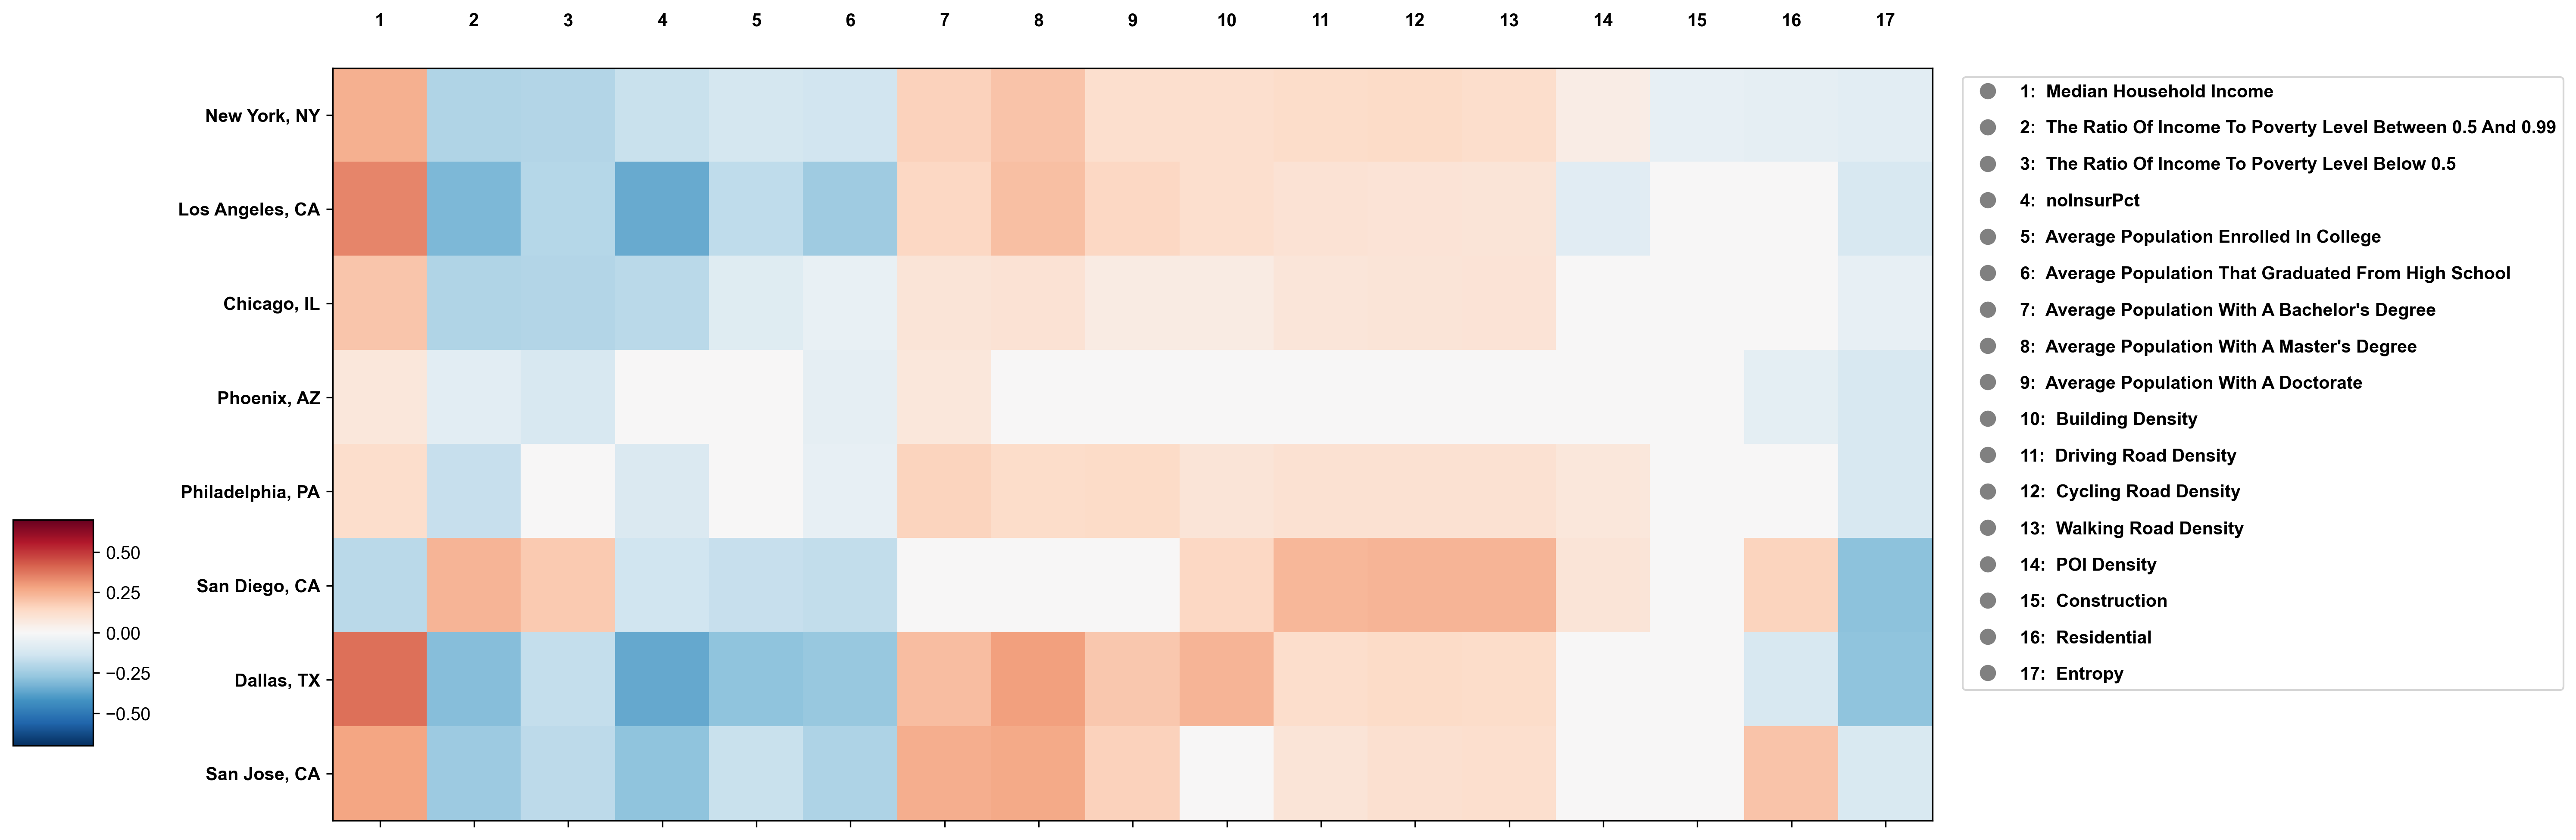

In [112]:
#data for ploting
df_results_all = {}
for city_id in city_list:
    # print(city_id)
    results = []
    for i in range(len(attributes_list_new)):
        attribute = attributes_list_new[i]
        # print(year,month,city_id,attribute)
        m, b, r2, p_value, correlation_xy=explore_relationship_city_attribute_pop_weighted(year, month, city_id, attribute, rank=True)
        results.append([attribute, m, b, r2, p_value, correlation_xy])

    df_results = pd.DataFrame(results, columns=["Attribute", "Slope", "Intercept", "R2","p-value", "Correlation Coefficient"])
    df_results_all[city_id] = df_results

data_dict = {}
selected_attributes_dict={}

for city_id in city_list:
    df = df_results_all[city_id]
    selected_attributes_city = df[df['p-value'] <= 0.05]['Attribute'].tolist()
    selected_attributes_dict[city_id]=selected_attributes_city
    data_dict[city_id] = df.set_index('Attribute')['Correlation Coefficient'].to_dict()
# print(data_dict)
matrix = []
for city_id in city_list:
    row = [data_dict[city_id].get(attr, 0) if attr in selected_attributes_dict[city_id] else 0 for attr in attributes_list_new]
    matrix.append(row)

matrix = np.array(matrix)

fig, ax = plt.subplots(figsize=(20, 10),dpi=300)

c = ax.imshow(matrix, cmap='RdBu_r', vmin=-0.7, vmax=0.7)#红蓝改了顺序

for idx, attr in enumerate(attributes_list_new):
    ax.text(idx, -1, str(idx+1), ha='center', va='center', color='black', fontsize=10, fontweight='bold')

print([city_name:=map_city[i] for i in city_list])
ax.set_yticks(np.arange(8))
ax.set_yticklabels([city_name:=map_city[i] for i in city_list], fontweight='bold')
ax.set_xticks(np.arange(len(attributes_list_new)))
ax.set_xticklabels([])  

from matplotlib.lines import Line2D
# id_to_attribute = {i+1: attr for i, attr in enumerate(attributes_list_new)}
id_to_attribute = {i+1: (attr.replace("A ", "The ") if attr.startswith("A Ratio") else attr) for i, attr in enumerate(attributes_list_new)}


legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, label=f"{i}:  {attr}") for i, attr in id_to_attribute.items()]

legend = plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.4, 1), labelspacing=1.1, prop={'weight': 'bold'})


axins = inset_axes(ax,
                width="5%",  
                height="30%",  
                loc='lower left',
                bbox_to_anchor=(-0.2, 0.1, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
fig.colorbar(c, cax=axins,orientation='vertical', pad=0.1, shrink=0.8)

plt.tight_layout()

plt.savefig(f"Heatmap_{year}_{month:02}.png",bbox_inches='tight',transparent=True)

plt.show()


### Produce data for the significant shift in the correlation coefficients around the critical connectivity threshold

In [ ]:
k_values = list(range(50, 551, 10))
for city_id in city_list:
    for k in range(50, 551, 10):
        print("city_id: ",city_id,"month: ",month,"k: ",k)
        results = []
        for i in range(len(attributes_list_new)):
            attribute = attributes_list_new[i]
            m, b, r2, p_value, correlation_xy=explore_relationship_city_attribute_anyk(year, month, city_id, attribute, k)
            results.append([attribute, m, b, r2, p_value, correlation_xy])
        df_results = pd.DataFrame(results, columns=["Attribute", "Slope", "Intercept", "R2","p-value", "Correlation Coefficient"])

        data_dir = ".\data\arbitrary_k"
        if not os.path.exists(data_dir):
            os.makedirs(data_dir)
        df_results.to_csv(f"{data_dir}\Results_{city_id}_{year}_{month}_kis{k}.csv", index=False)

### Plot the significant shift graph

Plot the graph on the significant shift in the correlation coefficients around the critical connectivity threshold

In [ ]:
attMarkersNew = {"Median Household Income": "o", \
    "A Ratio Of Income To Poverty Level Between 0.5 And 0.99": "s",\
    "A Ratio Of Income To Poverty Level Below 0.5": "^", \
    "noInsurPct": "H", "Average Population Enrolled In College": "D", "Average Population That Graduated From High School": "P", \
    "Average Population With A Bachelor's Degree": "<", "Average Population With A Master's Degree": "X", "Average Population With A Doctorate": "v",\
    "Building Density": "d", "Driving Road Density": "*",
    "Cycling Road Density": "o", "Walking Road Density": "s",
    "POI Density": "^", "Construction": "H", "Residential": "D",
    "Entropy": "P"}

attMarkerSizeNew={"Median Household Income": 3, \
    "A Ratio Of Income To Poverty Level Between 0.5 And 0.99": 3,\
    "A Ratio Of Income To Poverty Level Below 0.5": 3, \
    "noInsurPct": 4, "Average Population Enrolled In College": 3, "Average Population That Graduated From High School": 4, \
    "Average Population With A Bachelor's Degree": 3, "Average Population With A Master's Degree": 3, "Average Population With A Doctorate": 3,\
    "Building Density": 3, "Driving Road Density": 4.5,
    "Cycling Road Density": 3, "Walking Road Density": 3,
    "POI Density": 3, "Construction": 4, "Residential": 3,
    "Entropy": 4}


for city_id in city_list:
    data_dir = ".\data\arbitrary_k"
    df2=df_results_all[city_id]
    selected_attributes = df2[df2['p-value'] <= 0.05]['Attribute'].tolist()
    city_name_k=map_city[city_id]
    realk = allk.loc[(allk['month'] == month) & (allk['year'] == year), str(city_name_k)]
    realk=int(realk)
    results_dict = {}
    k_values = list(range(50, 411, 10))
    for k in range(50, 411, 10):
        filename = f"{data_dir}\Results_{city_id}_{year}_{month}_kis{k}.csv"
        df = pd.read_csv(filename)
        for attribute in attributes_list_new:
            if attribute not in results_dict:
                results_dict[attribute] = []
            results_dict[attribute].append(df[df['Attribute'] == attribute]['p-value'].values[0])
    
    colors = plt.cm.tab20.colors 

    fig, ax = plt.subplots(figsize=(10, 4.5), dpi=300)
    adjusted_colors = [color for i, color in enumerate(colors) if (i != 15 and i!=16)]

    for idx, (attribute, p_values) in enumerate(results_dict.items()):
        # print(attribute)
        if attribute not in selected_attributes:
            ax.plot(k_values, p_values,alpha=0.4, label=attribute, marker='x', color=colors[15],markersize=3, linewidth=1)  
        else:
            attr=attribute.replace("A ", "The ") if attribute.startswith("A Ratio") else attribute
            ax.plot(k_values, p_values,alpha=0.7, label=f"{attr}", marker=attMarkersNew[attribute], color=adjusted_colors[idx % len(adjusted_colors)],markersize=attMarkerSizeNew[attribute],linewidth=1)
    ax.axhline(y=0.05, color='#61C9A8', linestyle='--')
    ax.axvline(x=realk, color='black', linestyle='--')
    ax.text(realk-10, 0.98, '     $k*$', fontsize=10)
    ax.set_xlim(50, 411)
    ax.set_xlabel('k value')
    ax.set_ylabel('p-value')
    ax.invert_yaxis()

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), labelspacing=1.0)

    plt.tight_layout()

    # Set the output directory and file name
    output_file = f"Significance_{map_city[city_id]}_{year}_{month}.png"
    plt.savefig(output_file, bbox_inches='tight', transparent=True)  # Save the figure to the specified directory
    plt.close(fig)  # Close the figure after saving to free up memory
    plt.show()

### Plot spatial distribution of Proportion of Principal Destinations (PPD) for New York

In [ ]:
year = 2018
month = 6
city_id = 1
percentile = 2

fig, ax = plt.subplots(figsize=(11, 5), dpi=300) 
explore_percolation_transition_share_single_city(year, month, city_id, percentile, ax, 0)
cmap = custom_cmap_RDBU  
norm = colors.Normalize(vmin=0.6, vmax=1.0)

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.09) 
cbar.set_label('PPD', fontsize=12)

plt.savefig(f"PPD_spatial_distribution_{map_city[city_id]}_{year}_{month}.png", bbox_inches='tight', transparent=True) 
plt.tight_layout()  
plt.show()
